In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
#### ALL PARAMETERS DEFINED HERE ####

supervised = True
augment = False

# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")
noiseModelsDir = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models\final")

# Choose parameters
upsamp = 2
DataNoiseLvl = 1 # "all",list of int, or int
GMMNoiseLvl = 1
bootstrapped = False
GMMsig = "n2v" # "n2v" or "avg", used for not bootstrapped models only
normSignalToObs = True # put True if signal was normalized to observations when creating GMM
normGMM = True # put True if data was normalized to create the GMM

checkNoiseModelDisplay = True

clean = "avg" # "n2v" or "avg", used for supervised
display = True # display images or not
clip = -3 # False or clip value
registration = False

# Get noise model name
if GMMNoiseLvl == "same":
    GMMNoiseLvl = DataNoiseLvl
if isinstance(GMMNoiseLvl,list):
    GMMNoiseLvlstr = ''.join(str(GMMNoiseLvl).split(', '))[1:-1]
else:
    GMMNoiseLvlstr = GMMNoiseLvl

if bootstrapped:
    GMMname = f"GMM_Noise{GMMNoiseLvlstr}_bootstrapped_Clip{clip}.npz"
else:
    GMMname = f"GMM_Noise{GMMNoiseLvlstr}_Sig{GMMsig.upper()}_Clip{clip}.npz"
print ("Noise model: ", GMMname)
assert os.path.exists(noiseModelsDir/GMMname)

# Load GMM
noise_model_params= np.load(str(noiseModelsDir / GMMname))
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)

print(f"Upsamp: {upsamp}")
print(f"Supervised: {supervised}")
print(f"Noise level: {DataNoiseLvl}")
print(f"GMM noise level: {GMMNoiseLvl}")
print(f"Clean: {clean}")
print(f"GMM: {GMMname}")

# Training prm
patch_size = 64
gaussian_noise_std = None

# Training-specific
beta = 0.4 # loss = recon_loss + beta * kl_loss
batch_size=64
virtual_batch = 8
lr=1e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=10

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
blocks_per_layer = 6
batchnorm = True
free_bits = 1.0

# Model name for saving
if isinstance(DataNoiseLvl,list):
    DataNoiseLvlstr = ''.join(str(DataNoiseLvl).split(', '))[1:-1]
else:
    DataNoiseLvlstr = DataNoiseLvl
data_name = str(data_path_signal).split("\\")[3]
if bootstrapped:
    sig = "boostrapped"
else:
    sig = GMMsig.upper()
modelName = f"{data_name}_Noise{DataNoiseLvlstr}_GMM{GMMNoiseLvlstr}{sig}_Clip{clip}_{num_latents}Lat_{blocks_per_layer}Blocks_betaKL{beta}"
if supervised:
    modelName = modelName + f"_Supervised{clean.upper()}"
if upsamp > 1:
    modelName = modelName + "_upsamp2random2addConvLayer"
if not augment:
    modelName = modelName + "_NoAugment"

save_model_basedir = "./Trained_model/" 
print(f"Trained model will be saved at: {save_model_basedir}")
print(f"Model save name: {modelName}")


Noise model:  GMM_Noise1_SigN2V_Clip-3.npz
Upsamp: 2
Supervised: True
Noise level: 1
GMM noise level: 1
Clean: avg
GMM: GMM_Noise1_SigN2V_Clip-3.npz
Trained model will be saved at: ./Trained_model/
Model save name: Vim_fixed_mltplSNR_30nm_Noise1_GMM1N2V_Clip-3_5Lat_6Blocks_betaKL0.4_SupervisedAVG_upsamp2random2addConvLayer_NoAugment



Found 25 files.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_01.tiff:	Observation rec_c02_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_02.tiff:	Observation rec_c03_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_03.tiff:	Observation rec_c04_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_04.tiff:	Observation rec_c05_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_05.tiff:	Observation rec_c07_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_06.tiff:	Observation rec_c08_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_07.tiff:	Observation rec_c09_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_08.tiff:	Observation rec_c10_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_09.tiff:	Observation rec_c11_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_10.tiff:	Observation rec_c12_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and

Text(0.5, 1.0, 'Clean')

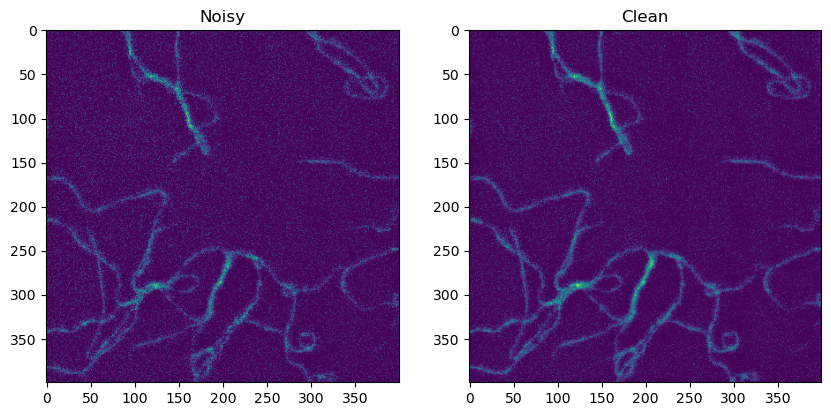

In [3]:
##### Load data ####
signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

if isinstance(DataNoiseLvl,list) or DataNoiseLvl == "all":
    mltplNoise = True
else:
    mltplNoise = False

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    
    # n2v or avg signal selection
    if clean == "avg":
        im_signal = imread(data_path_signal / file_signal)[0]
    elif clean == "n2v":
        im_signal = imread(data_path_signal / file_signal)[1]
    
    # noise level selection
    if DataNoiseLvl == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(DataNoiseLvl,int) or isinstance(DataNoiseLvl,list):
        im_obs = imread(data_path_obs / file_obs)[DataNoiseLvl]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    if registration:
        if DataNoiseLvl == "all":
            print("Registration not available for all noise level yet")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

signal = np.stack(signal)
observation = np.stack(observation)

if mltplNoise:
    nNoise = observation.shape[1]
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nrepeat,axis=0)


if signal.shape[-1] != signal.shape[-2]:
    print("Cropping to square")
    a = min(signal.shape[-1],signal.shape[-2])
    signal = signal [...,0:a,0:a]
    observation = observation [...,0:a,0:a]

if normSignalToObs:
    if mltplNoise:
        signal = (signal - np.mean(signal))/np.std(signal)
        for noise in range(nNoise):
            signal[noise::nNoise] = signal[noise::nNoise] * np.std(observation[noise::nNoise]) + np.mean(observation[noise::nNoise])
    else:
        signal = (signal - np.mean(signal))/np.std(signal)
        signal = signal * np.std(observation) + np.mean(observation)

if normGMM:
    signal = (signal - np.mean(observation)) / np.std(observation)
    observation = (observation - np.mean(observation)) / np.std(observation)

print("After normalization:")
print(f"Mean signal {np.mean(signal)}, std signal {np.std(signal)} ")
print(f"Mean observation {np.mean(observation)}, std observation {np.std(observation)} ")

print(f"\n\nConcatenated arrays:\tSignal: {signal.shape}\tObservation: {observation.shape}")

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(observation[0][400:800,400:800])
plt.title("Noisy")

plt.subplot(1,2,2)
plt.imshow(signal[0][400:800,400:800])
plt.title("Clean")

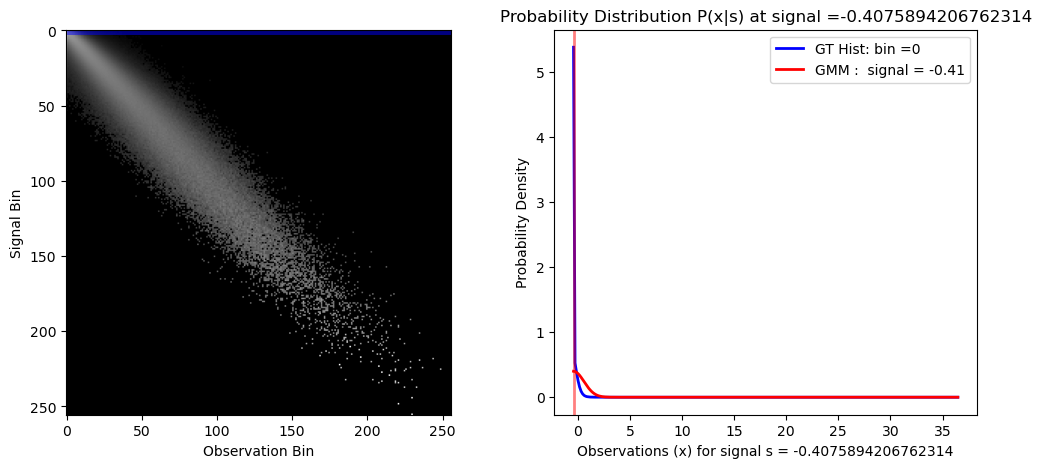

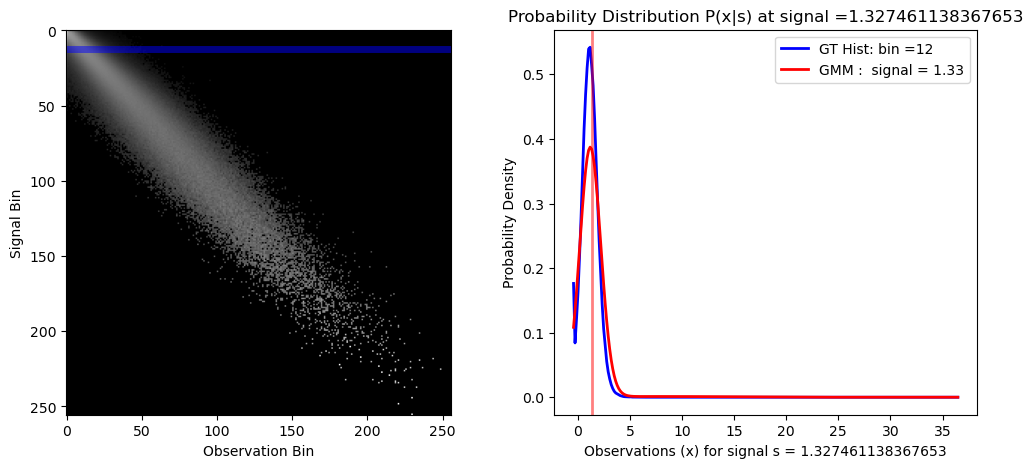

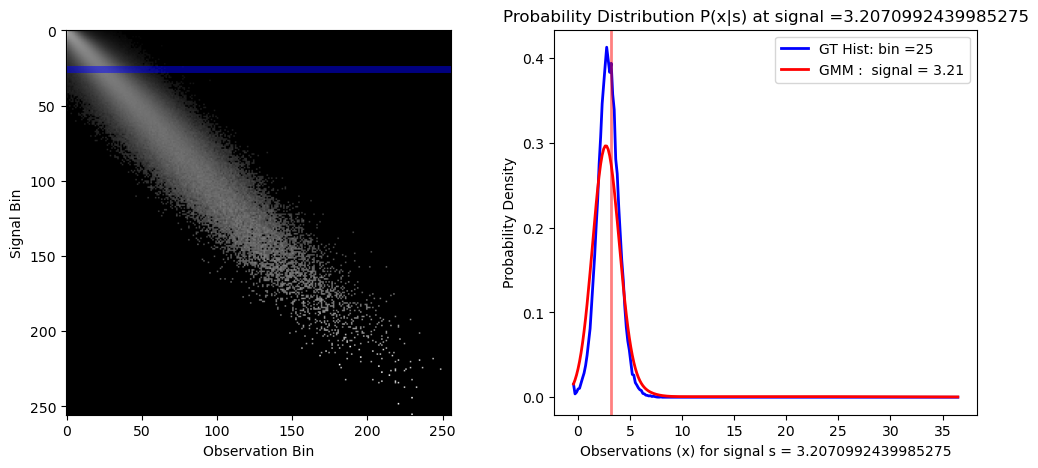

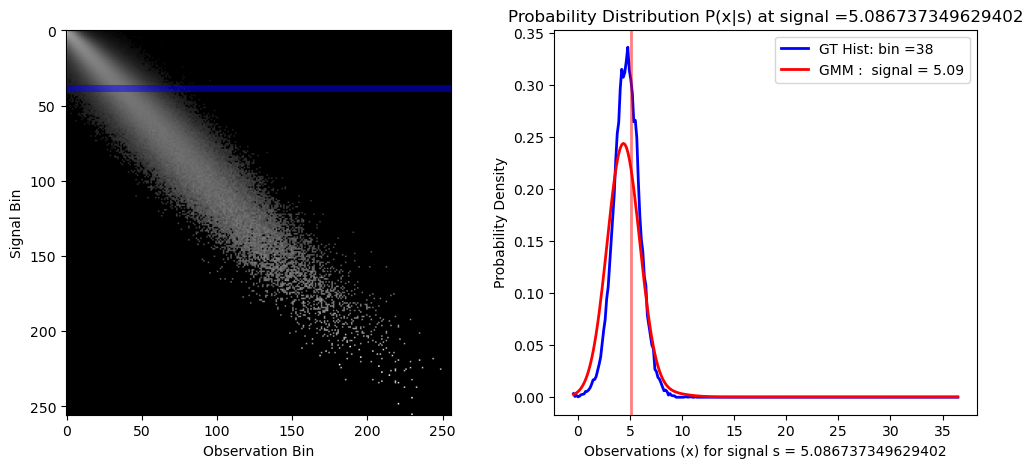

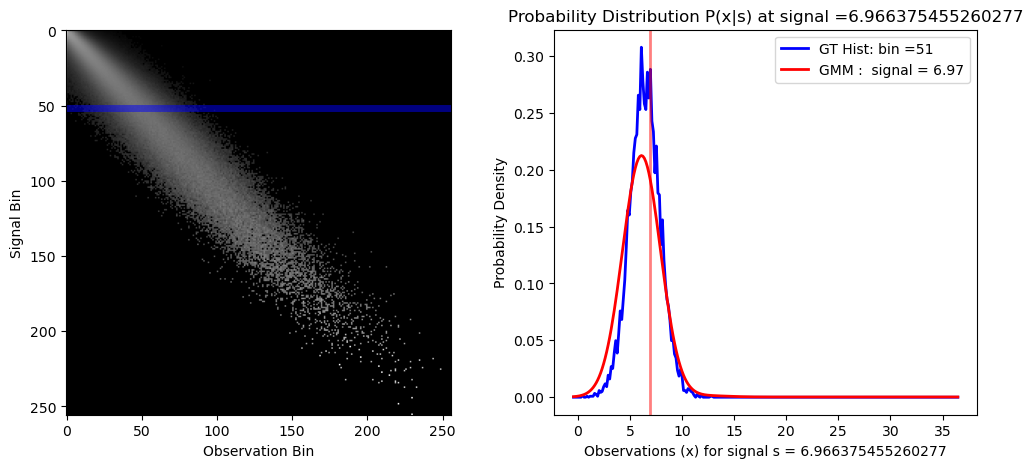

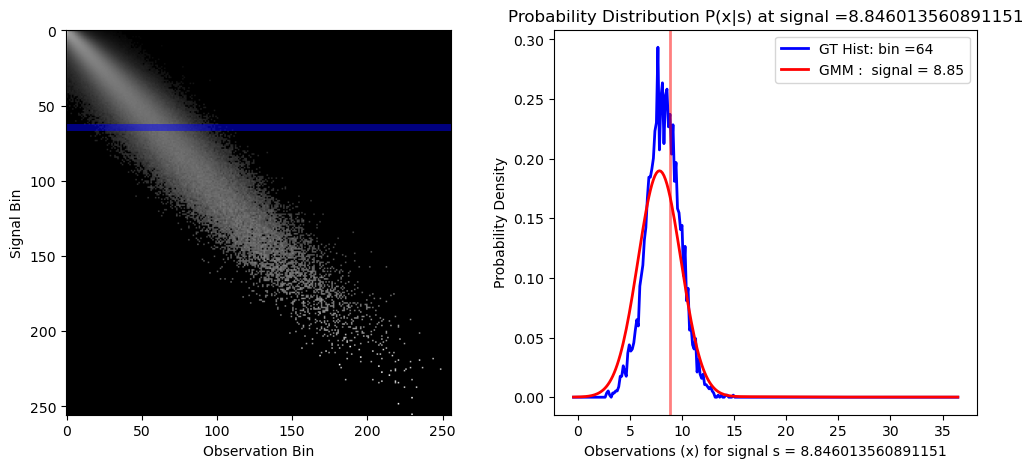

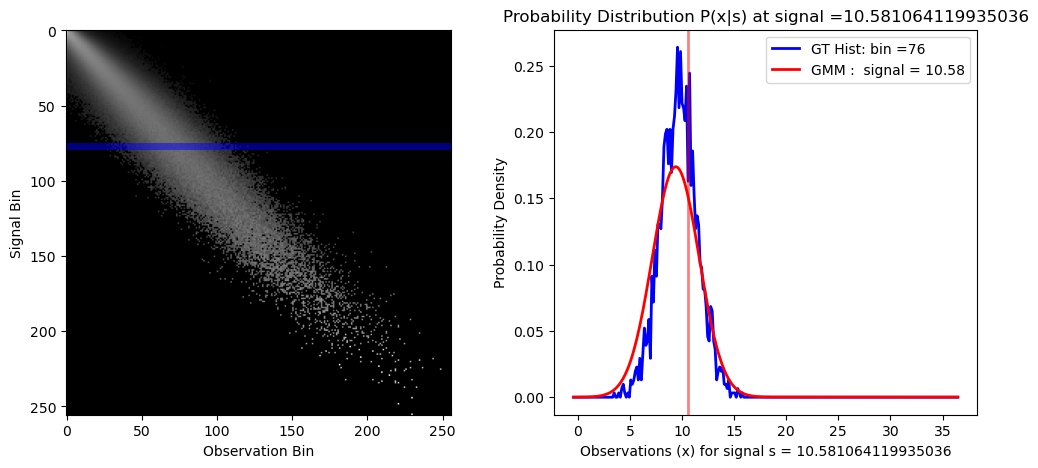

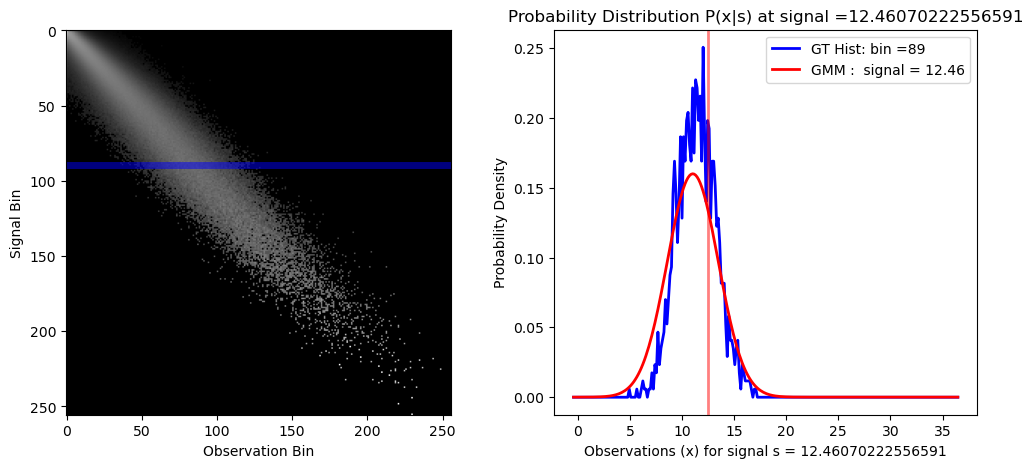

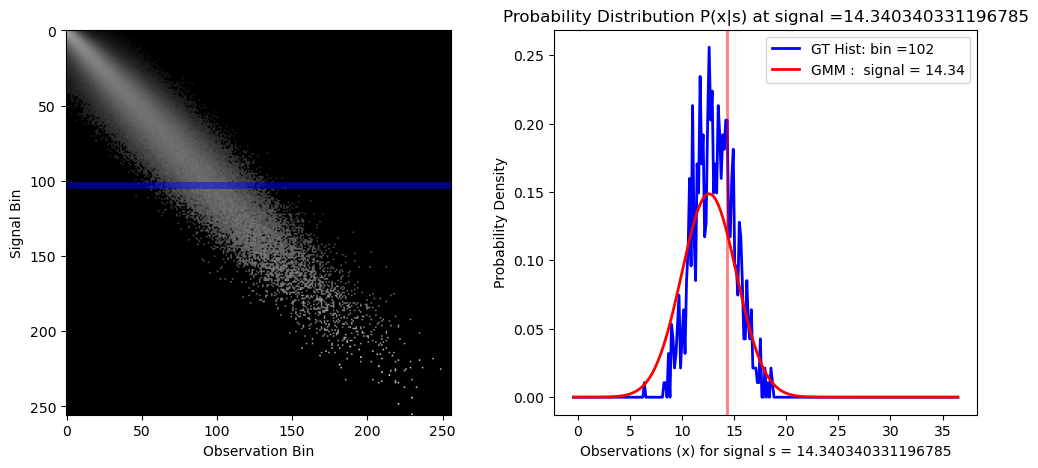

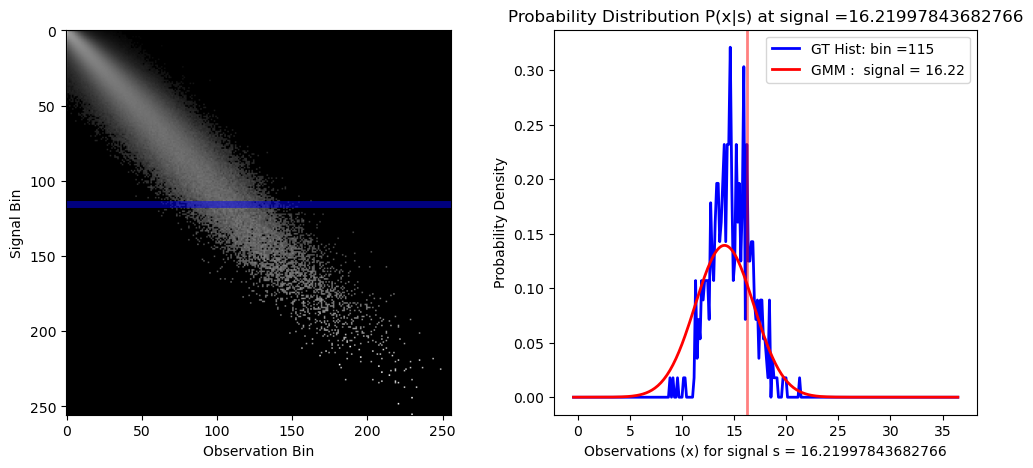

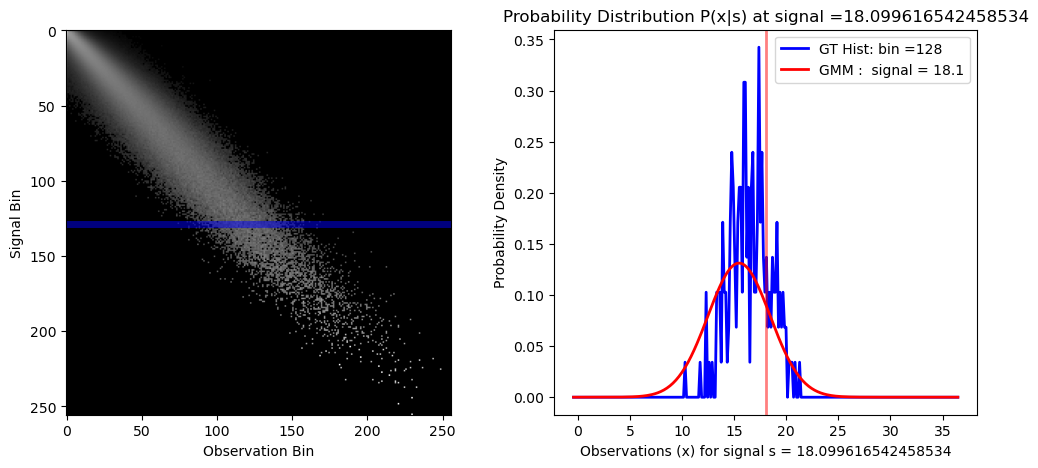

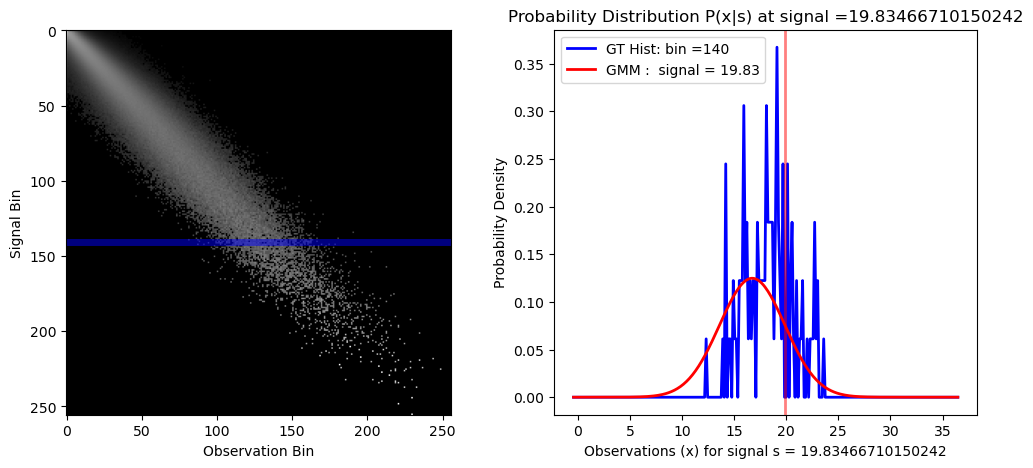

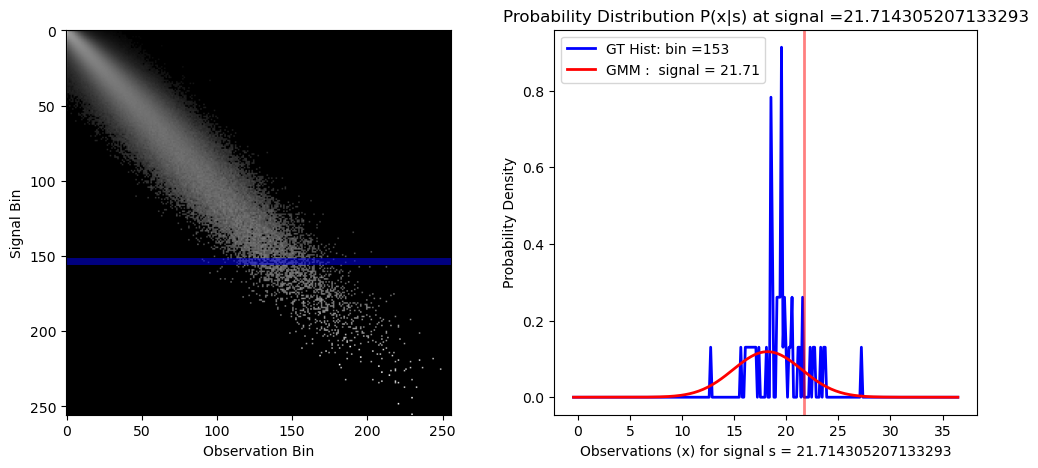

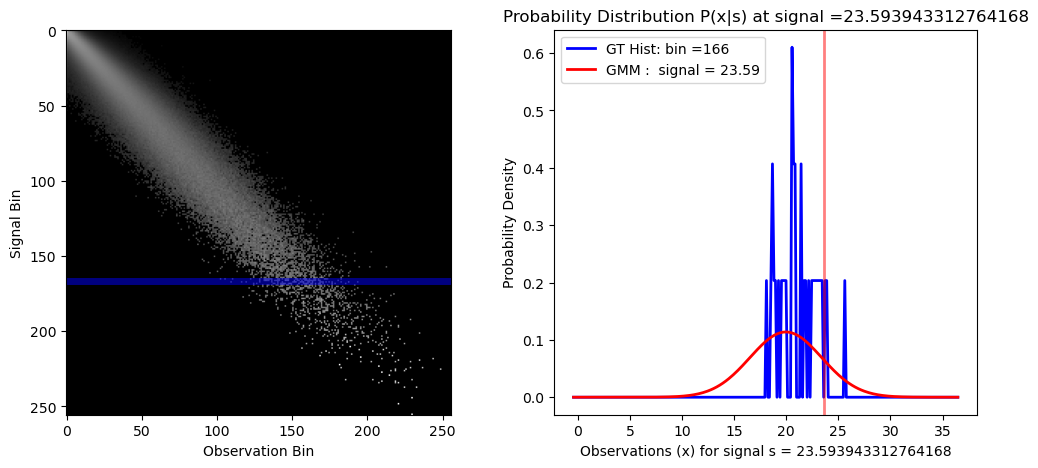

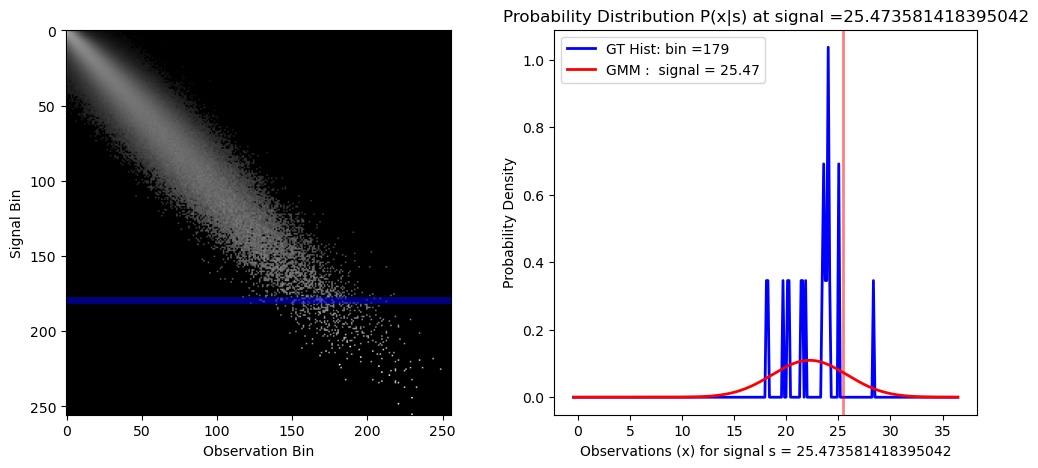

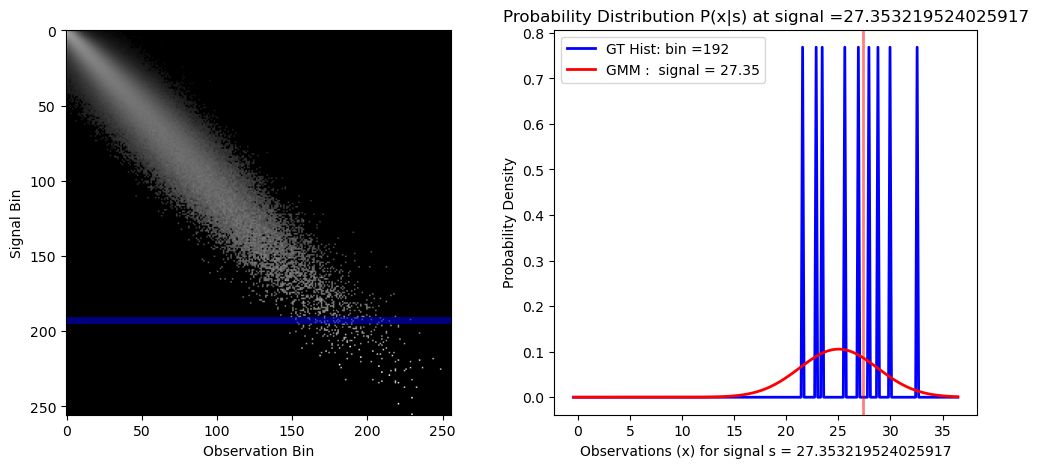

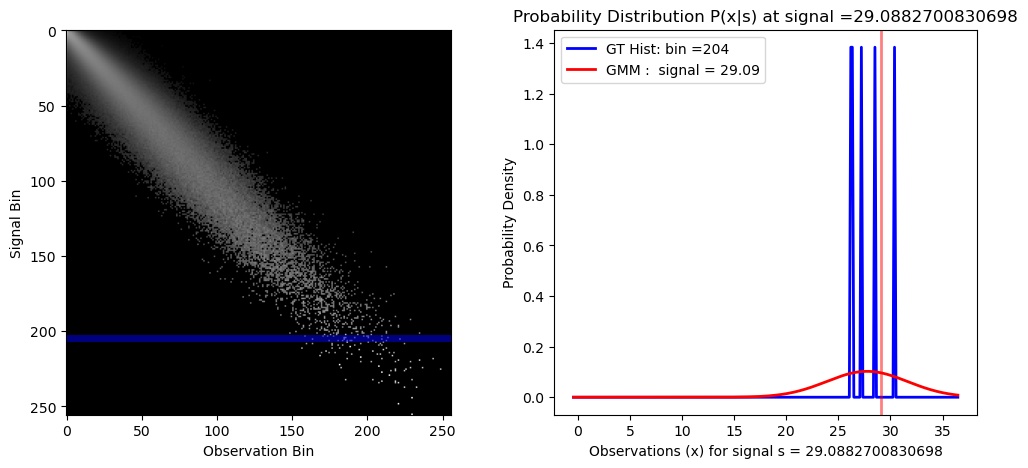

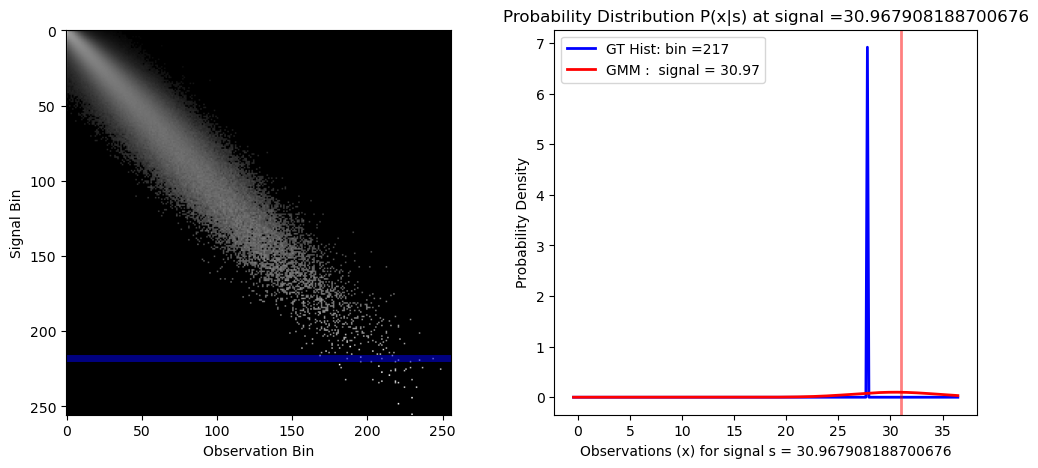

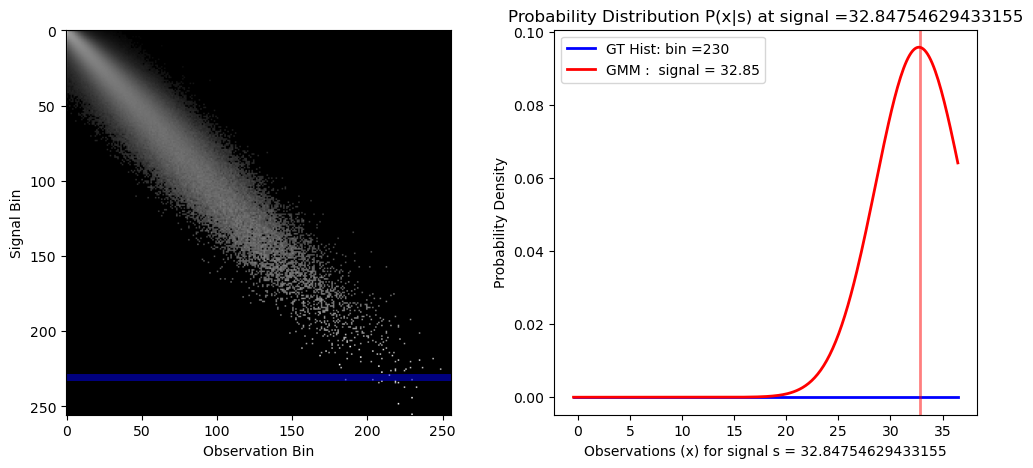

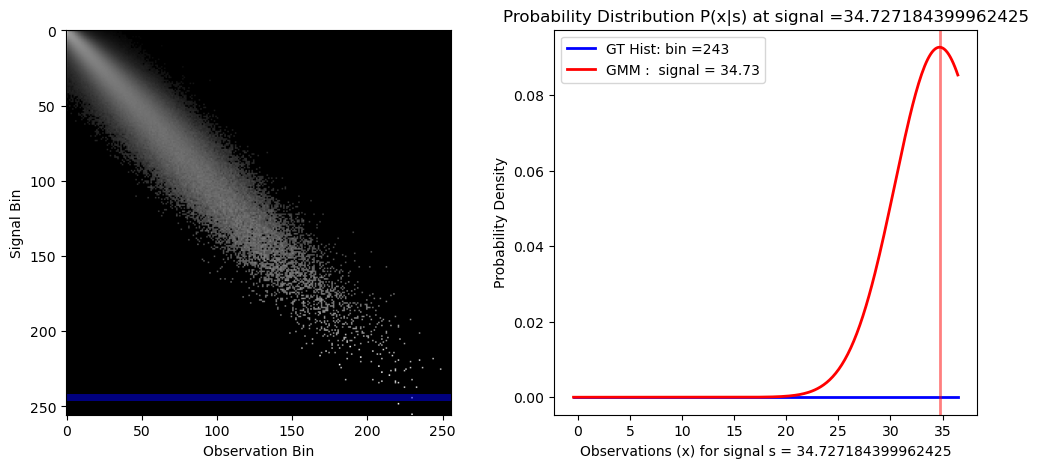

In [4]:
# Optional display of Noise Model with data histogram to check that it matches 
# NOTE: does not make sense for bootstrapped histogram!
n_points = 20
bins=256
minVal = np.min(signal)
maxVal =  np.max(signal)
if checkNoiseModelDisplay:
    histogram = histNoiseModel.createHistogram(bins, minVal,maxVal, observation,signal)
    signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*bins//n_points).astype(int)

    for binidx in signalBinIndex_list:
        plotProbabilityDistribution(signalBinIndex=binidx, histogram=histogram[0], gaussianMixtureNoiseModel=noiseModel, min_signal=minVal, max_signal=maxVal, n_bin=bins, device=device)

In [5]:

# Split into train and val, define gt data if supervised

train_data = observation[:int(0.85*observation.shape[0])]
val_data= observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
if augment:
    train_data = utils.augment_data(train_data) ### Data augmentation disabled for fast training, but can be enabled
### Optional part with GT data if supervised###
if supervised:
    train_data_gt = signal[:int(0.85*observation.shape[0])]
    val_data_gt = signal[int(0.85*observation.shape[0]):]
    print("Shape of GT training images:", train_data.shape, "Shape of validation images:", val_data.shape)
    if augment:
        train_data_gt = utils.augment_data(train_data_gt) ### Data augmentation disabled for fast training, but can be enabled

Shape of training images: (21, 1392, 1392) Shape of validation images: (4, 1392, 1392)
Shape of GT training images: (21, 1392, 1392) Shape of validation images: (4, 1392, 1392)


In [6]:
# Patches extraction

img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)

if not supervised:
    train_images = utils.extract_patches(train_data, patch_size, num_patches)
    val_images = utils.extract_patches(val_data, patch_size, num_patches)
else:
    train_images,train_images_gt = utils.extract_patches_supervised(train_data,train_data_gt, patch_size, num_patches)
    val_images,val_images_gt  = utils.extract_patches_supervised(val_data,val_data_gt, patch_size, num_patches)

 # We limit validation patches to 1000 to speed up training but it is not necessary
val_images = val_images[:1000]
test_images = val_images[:100]
if supervised:
    val_images_gt = val_images_gt [:1000] 
    test_images_gt = val_images_gt[:100]
    
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 74.21it/s]

Shape of training images: (9933, 64, 64) Shape of validation images: (1000, 64, 64)


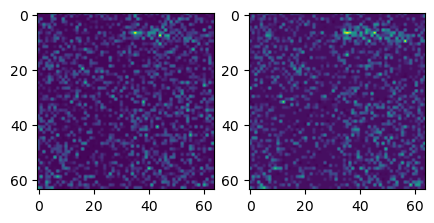

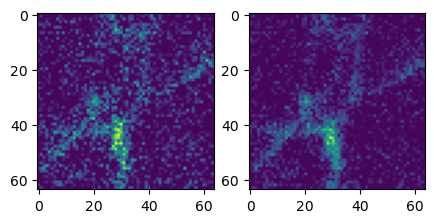

In [7]:
# if supervised: Display of paired dataset to check that it is matching 

if supervised:
    import random
    idx = random.randrange(train_images.shape[0])

    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(train_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(train_images_gt[idx])

    idx = random.randrange(val_images.shape[0])
    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(val_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(val_images_gt[idx])

In [8]:
# Choose make_data_manager for supervised training or make_data_manager 2 for supervised

if upsamp>1 or supervised:
    if not supervised:
        train_images_gt = train_images.copy()
        val_images_gt = val_images.copy()
        test_images_gt = test_images.copy()

    train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager_supervised(train_images,train_images_gt,val_images,
                                                                                            val_images_gt, test_images,test_images_gt,
                                                                                            batch_size,test_batch_size,upsamp=upsamp)

else:
    train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
                                                                                            test_images,batch_size,
                                                                                            test_batch_size)


# Here we ensure that steps_per_epoch not bigger than len(train_loader)
# It never goes into validation otherwise, and so it never saves the model.
steps_per_epoch=min(len(train_loader)-1,steps_per_epoch)
print(steps_per_epoch)

155


In [9]:
print(data_mean,data_std)

0.035245357887557595 1.0712245514920642


(32, 32)
(32, 32)


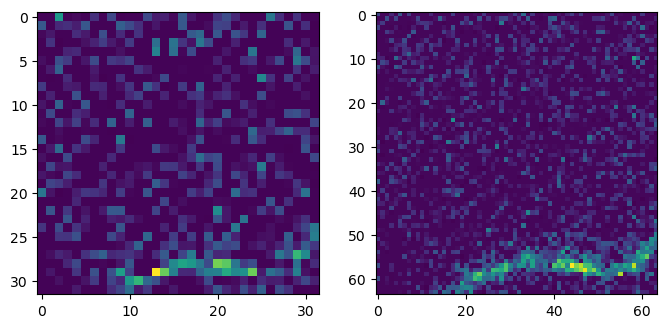

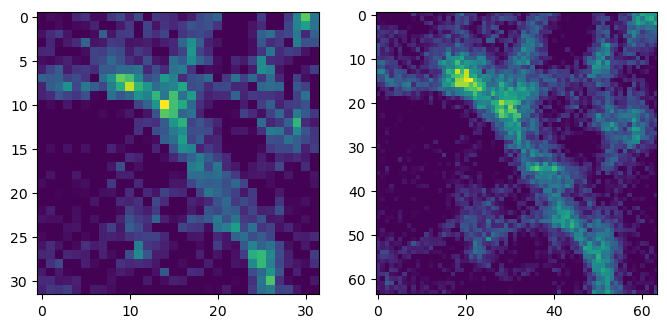

In [10]:


# if supervised: Display of paired dataset to check that it is still matching in the loader  

if supervised or upsamp > 1:
    batch_idx, (x, y) = next(enumerate(train_loader))

    x2 = x.cpu().numpy()
    x2 = x2[0]
    print(x2.shape)

    y2 = y.cpu().numpy()
    y2 = y2[0]

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(x2)
    plt.subplot(1,2,2)
    plt.imshow(y2)

    batch_idx, (x, y) = next(enumerate(val_loader))

    x2 = x.cpu().numpy()
    x2 = x2[0]
    print(x2.shape)

    y2 = y.cpu().numpy()
    y2 = y2[0]

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(x2)
    plt.subplot(1,2,2)
    plt.imshow(y2)

In [ ]:
# Train network


model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape,final_upsamp=True).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=save_model_basedir,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=modelName,val_loss_patience=100,beta=beta)

Epoch[1/500] Training Loss: 1.298 Reconstruction Loss: 1.216 KL Loss: 0.206
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise1_GMM1N2V_Clip-3_5Lat_6Blocks_betaKL0.4_SupervisedAVG_upsamp2random2addConvLayer_NoAugment_last_vae.net
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise1_GMM1N2V_Clip-3_5Lat_6Blocks_betaKL0.4_SupervisedAVG_upsamp2random2addConvLayer_NoAugment_best_vae.net
Patience: 0 Validation Loss: 1.1256670951843262 Min validation loss: 1.1256670951843262
Time for epoch: 221seconds
Est remaining time: 1 day, 6:37:59 or 110279 seconds
----------------------------------------
Epoch[2/500] Training Loss: 1.195 Reconstruction Loss: 1.154 KL Loss: 0.101
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise1_GMM1N2V_Clip-3_5Lat_6Blocks_betaKL0.4_SupervisedAVG_upsamp2random2addConvLayer_NoAugment_last_vae.net
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise1_GMM1N2V_Clip-3_5Lat_6Blocks_betaKL0.4_SupervisedAVG_upsamp2random2addConvLayer_NoAugment_best

# Plotting losses

In [ ]:
directory_path = "./Trained_model/" 
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

In [ ]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()